## Goal: Build a classification model to predict spend range for tech companies

## Import Libraries and Data

In [303]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [304]:
comp = pd.read_csv("competitive_master.csv")

In [305]:
comp.describe()

,Unnamed: 0,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Total Persons 12+,Month,Spend_K,Year
count,2.159350e+05,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,5.492127e+05,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,2.986108e+05,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,0.000000e+00,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,3.040425e+05,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,5.497940e+05,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,8.135210e+05,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,1.037422e+06,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [306]:
comp.columns

Index(['Unnamed: 0', 'INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET',
       'MEDIA', 'Company', 'Rank', 'Revenue_Billion', 'Financial Year',
       'Employees', 'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', ' Total Persons 12+ ',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [307]:
comp=comp.drop('Unnamed: 0', axis=1)

In [308]:
comp=comp.rename(columns={" Total Persons 12+ ":"Audience Population"})

## Data Exploration

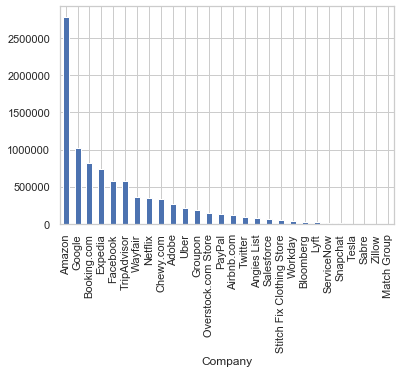

In [309]:
#Competitor's National Advertising Spend Rank

comp[comp['DMA_Code']==0].groupby(['Company'])['Spend_K'].sum().sort_values(ascending=False).plot.bar()

In [310]:
national_spend = comp[(comp['DMA_Code']==0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
nat_spend_revenue_ratio = national_spend/avg_revenue/1000000

In [311]:
nat_spend_revenue_ratio.head()

Company
Adobe          0.013870
Airbnb.com     0.020704
Amazon         0.004741
Angies List    0.029709
Bloomberg      0.001041
dtype: float64

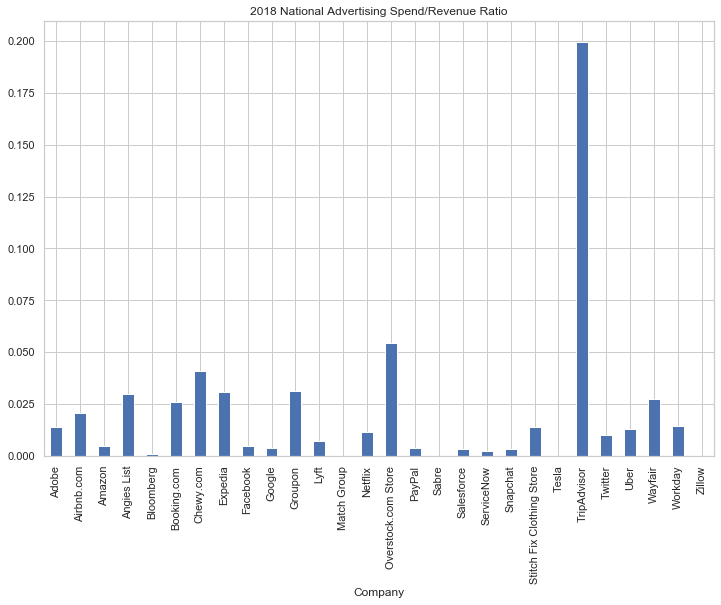

In [370]:
nat_spend_revenue_ratio.plot.bar(figsize=(12,8),title='2018 National Advertising Spend/Revenue Ratio')

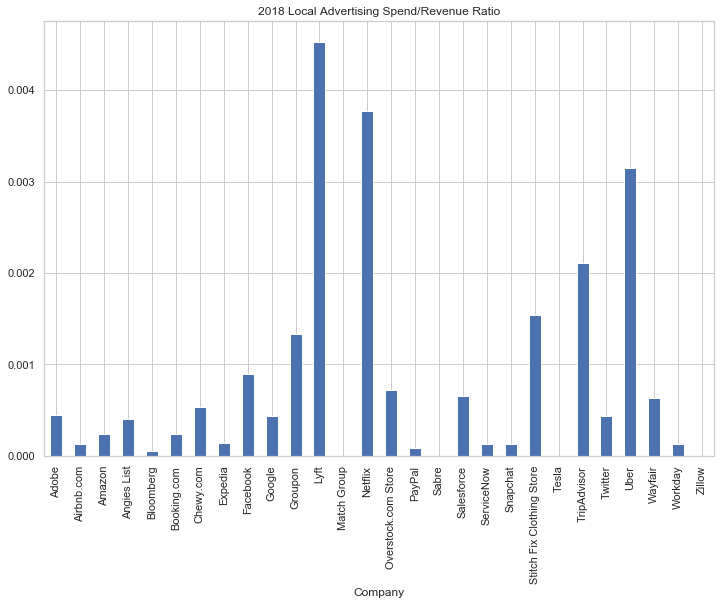

In [369]:
local_spend = comp[(comp['DMA_Code']!=0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
local_spend_revenue_ratio = local_spend/avg_revenue/1000000
local_spend_revenue_ratio.plot.bar(figsize=(12,8),title='2018 Local Advertising Spend/Revenue Ratio')

Insight: TripAdvisor spent largest % of their revenue in National advertising, while Lyft, Uber and Netflix spent more in local markets because their marketing efforts are more market-diven

Text(0.5, 1.0, 'Annual Revenue')

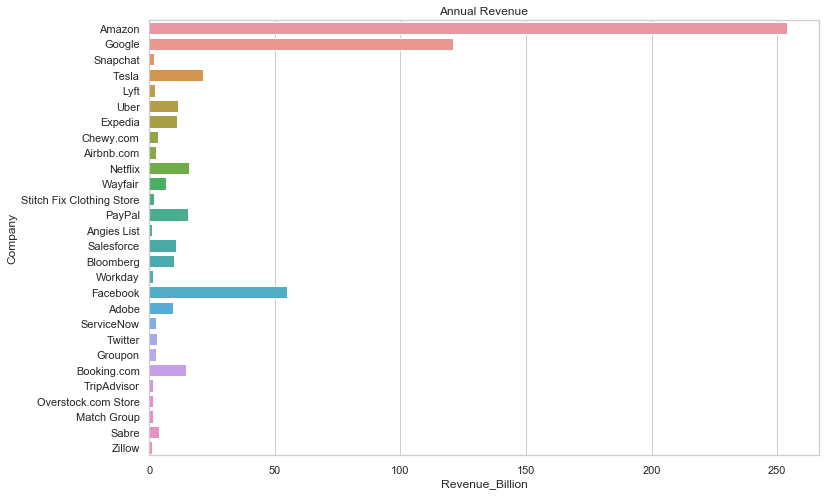

In [368]:
plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
ax = sns.barplot(y='Company', x='Revenue_Billion', data=comp)
plt.title('Annual Revenue')

Add more charts on Media Mix, Market Distribution later


## Data Processing

In [315]:
comp.describe()

,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Audience Population,Month,Spend_K,Year
count,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [316]:
comp.columns

Index(['INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET', 'MEDIA',
       'Company', 'Rank', 'Revenue_Billion', 'Financial Year', 'Employees',
       'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', 'Audience Population',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [317]:
#Remove Industry, Parent, Advertiser, Brand, Nielsen DMA, Region Name

comp_df = pd.pivot_table(comp, values=['BRAND','Rank','Revenue_Billion','Employees','Market cap_Billion','Founded','IsTop31','Audience Population','Spend_K'],
                        index = ['Company','DMA_Code','MEDIA','Division_Name','Year','Month'],
                        aggfunc={'BRAND':'count', 'Rank':np.mean, 'Revenue_Billion':np.mean, 'Employees':np.mean, 'Market cap_Billion':np.mean, 'Founded':np.mean,'Audience Population': np.mean,'Spend_K':np.sum, 'IsTop31': np.mean })

In [318]:
comp_df = comp_df.reset_index()

There is a huge gap between National Spend and Local Spend. To get more accurate and reasonable mode, we separate National and Local. 

In [319]:
#turn DMA_Code, IsTop31 to Categorical values
comp_df['DMA_Code'] = comp_df['DMA_Code'].astype('category')
comp_df['IsTop31'] = comp_df['IsTop31'].astype('category')

In [320]:
#duplicate Rank as Company ID 
comp_df['Company_ID']=comp_df['Rank'].astype('category')

In [321]:
#Create dummies for MEDIA and Division
media = pd.get_dummies(comp_df['MEDIA'], prefix='Media')
division = pd.get_dummies(comp_df['Division_Name'], prefix='Div')

In [322]:
comp_df_new = pd.concat([comp_df, media, division],axis=1)

In [323]:
comp_df_new.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


### National Spend data set

In [348]:
nat_comp_df = comp_df_new[comp_df_new['DMA_Code']==0]
nat_comp_df.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


In [325]:
nat_comp_df = nat_comp_df.drop(columns=['Company','Div_ALL OTHER','Div_Central','Div_National','Div_Northeast','Div_West','Division_Name','MEDIA','DMA_Code'], axis=1)

#### Create Bins for Spend_K

In [328]:
nat_comp_df.Spend_K.quantile(list(np.linspace(0,1,11)))

0.0        0.00
0.1        6.10
0.2       29.48
0.3       86.60
0.4      192.34
0.5      399.95
0.6      737.60
0.7     1376.33
0.8     2490.18
0.9     6015.89
1.0    92615.30
Name: Spend_K, dtype: float64

In [329]:
#75% values are between 0 to 12000
BINS = [0,10,30,50,80,100,150,200,400,600,800,1000,1500,2000,3000,5000,8000,10000,15000,100000]

In [330]:
nat_comp_df['Spend_Bins'] = pd.cut(x=nat_comp_df.Spend_K, bins=BINS, labels=False)

In [331]:
nat_comp_df['Spend_Bins']

0        7.0
1        0.0
2        7.0
3        7.0
4        9.0
        ... 
95727    0.0
95728    0.0
95729    0.0
95730    0.0
95731    1.0
Name: Spend_Bins, Length: 3578, dtype: float64

In [332]:
nat_comp_df = nat_comp_df.drop('Spend_K', axis=1)

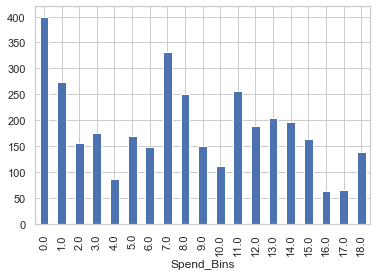

In [333]:
nat_comp_df.groupby('Spend_Bins')['BRAND'].count().plot.bar()

In [334]:
#Remove all NAs
nat_comp_df = nat_comp_df.dropna(how='any')

### Local Market Level Spend Data

In [350]:
local_df = comp_df_new[comp_df_new['DMA_Code']!=0]
local_df.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
118,Adobe,500,Int Display,Northeast,2018,1,892300,5,21200,1982,...,0,0,0,0,0,0,0,0,1,0
119,Adobe,500,Int Display,Northeast,2018,2,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
120,Adobe,500,Int Display,Northeast,2018,3,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
121,Adobe,500,Int Display,Northeast,2018,4,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
122,Adobe,500,Int Display,Northeast,2018,5,892300,5,21200,1982,...,0,0,0,0,0,0,0,0,1,0


In [351]:
local_df.Spend_K.quantile(list(np.linspace(0,1,11)))

0.0       0.0
0.1       0.0
0.2       0.0
0.3       0.0
0.4       0.0
0.5       0.1
0.6       0.2
0.7       0.5
0.8       1.4
0.9       6.0
1.0    2390.1
Name: Spend_K, dtype: float64

Local Spend looks very umbalanced and minimal compared to National Spend. We will focus on National Spend first. d

## Training, testing and cross-validation

In [273]:
#Split the data into training and test sets
y = nat_comp_df['Spend_Bins']
X = nat_comp_df.drop('Spend_Bins', axis=1)

In [274]:
y

0         9.0
1         1.0
2         8.0
3         9.0
4        10.0
         ... 
95727     0.0
95728     0.0
95729     0.0
95730     0.0
95731     3.0
Name: Spend_Bins, Length: 3306, dtype: float64

### Standaridize the data set

In [275]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
scaled_features = pd.DataFrame(scaled, columns=X.columns)

In [276]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.25, random_state=4)

### Build the Base Model

In [288]:
#Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [289]:
forest.score(X_train, y_train)

0.9640984267849939

In [290]:
forest.score(X_test, y_test)

0.2781136638452237

### Grid Search

In [297]:
forest_grid = {
    'n_estimators':[5,10,15,20,25,30],
    'criterion':['gini','entropy'],
    'max_depth':[None,5,8,10,13],
    'min_samples_split':[2,5,10,20]
      
}

In [298]:
forest_grid_search = GridSearchCV(forest, forest_grid, cv=3, return_train_score = True, n_jobs=1)
forest_grid_search.fit(X_train, y_train)

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [299]:
# Mean training score
forest_gs_training_score = np.mean(forest_grid_search.cv_results_['mean_train_score'])

# Mean test score
forest_gs_testing_score = forest_grid_search.score(X_test, y_test)

print("Mean Training Score: ", forest_gs_training_score)
print("Mean Test Score: " , forest_gs_testing_score)
print("Best Parameter Combination Found During Grid Search:")
forest_grid_search.best_estimator_
forest_grid_search.best_params_

Mean Training Score:  0.5220292765579677
Mean Test Score:  0.28657799274486095
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 5,
 'n_estimators': 30}

The training score is worse than the baseline, the test score is just slightly higher than the baseline.

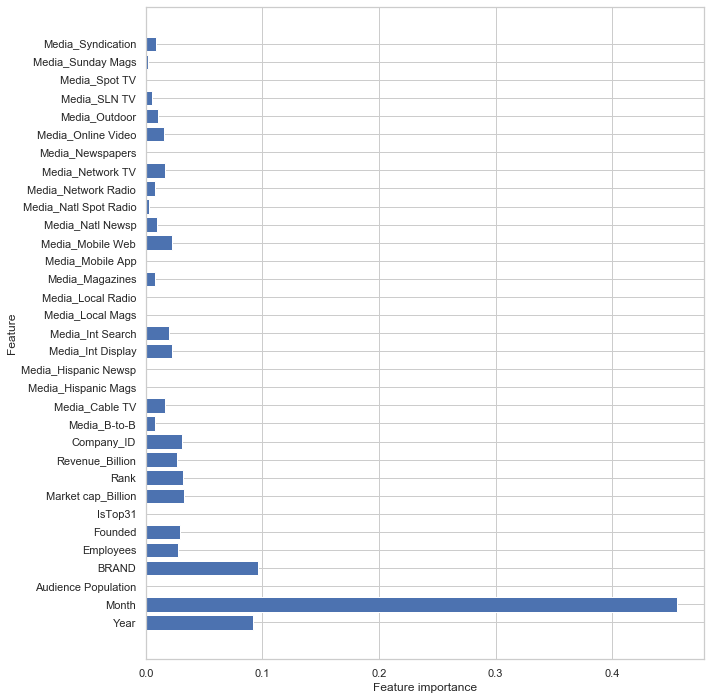

In [301]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


plot_feature_importances(forest)

### TRY PIPELINE!!!

In [361]:
#Create the pipeline and include PCA in the process
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([
                ('pca', PCA(n_components=3)),
                ('tree', RandomForestClassifier())])

# Create the grid parameter
grid = [{'tree__n_estimators':[5,10,15,20,25,30],
    'tree__criterion':['gini','entropy'],
    'tree__max_depth':[None,5,8,10,13],
    'tree__min_samples_split':[2,5,10,20]}]

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=3, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('tree',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                              

In [363]:
print('Test accuracy: %.3f' % gridsearch.score(X_test, y_test))

Test accuracy: 0.242


In [366]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

## KEEP IT FOR NOW
# Construct some pipelines
pipe_svm = Pipeline([('pca', PCA(n_components=25)),
        ('clf', svm.SVC(random_state=123))])
        
pipe_tree = Pipeline([('pca', PCA(n_components=25)),
        ('clf', tree.DecisionTreeClassifier(random_state=123))])

pipe_rf = Pipeline([('pca', PCA(n_components=25)),
        ('clf', RandomForestClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=25,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=123, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=25,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=123,
                                        splitter='best'))],
         verbose=False)
Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto',

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Support Vector Machine pipeline test accuracy: 0.169
Decision Tree pipeline test accuracy: 0.245
Random Forest pipeline test accuracy: 0.268


In [367]:
# Construct pipeline
pipe_rf = Pipeline([('pca', PCA(n_components=25)),
            ('clf', RandomForestClassifier(random_state = 123))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [10,20,30],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [None, 4, 5, 6],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.4s
[CV] clf__criterion=entropy, clf__max

[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=

[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=None, c

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.8s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2

[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_l

[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=None, clf__min_samples_l

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samp

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=10, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_sampl

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=10, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=20, total=   0.0s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=30 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=30, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  1.9min finished
C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best accuracy: 0.180

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 30}
